# Cats vs Dogs
#### We are gonna build a deep learning model to detect cat and dog.
##### We will use Keras library to build the model.

### Importing libraries

In [113]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
print('setup done')

setup done


### Preparing dataset 

In [114]:
import zipfile
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip", 'r') as zip_ref:
    zip_ref.extractall("../train/train/train/")

In [115]:
filenames = os.listdir("../train/train/train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
print('Preparation done')

Preparation done


In [116]:
df.head()

,filename,category
0,dog.890.jpg,1
1,dog.1178.jpg,1
2,dog.7845.jpg,1
3,dog.4632.jpg,1
4,cat.3660.jpg,0


Now lets do some operations on dataset

In [117]:
cat, dog = 1, 0
print(f'number of dogs: {len(df[df.category == dog])}')
print(f'number of cats: {len(df[df.category == cat])}')

number of dogs: 12501
number of cats: 12500


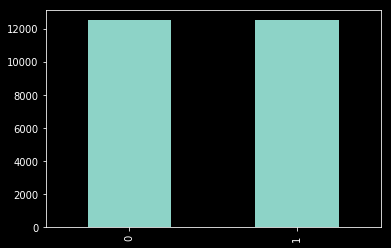

In [118]:
plt.style.use('dark_background')
df['category'].value_counts().plot.bar()

Now lets see some images randomly

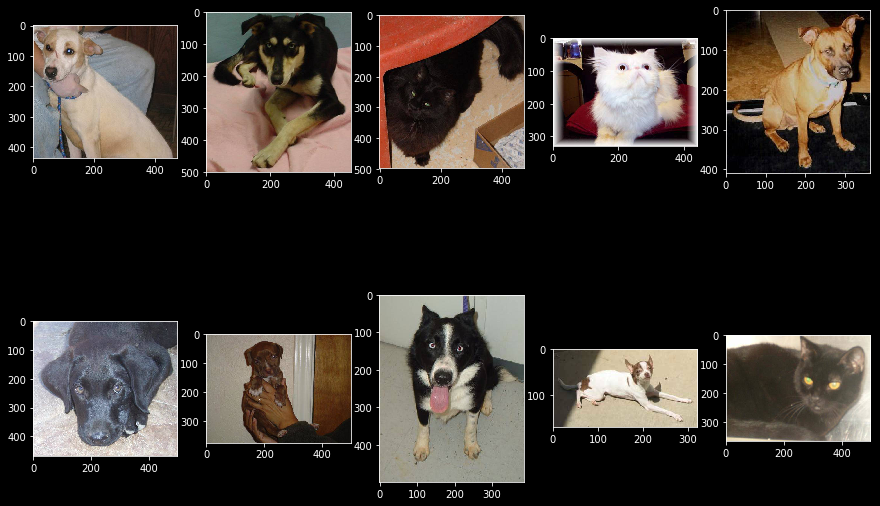

In [119]:
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    sample = random.choice(filenames)
    image = load_img("../train/train/train/" + sample)
    plt.imshow(image)

As you can see , it seems size of images are different from each other

### Now lets build the model

In [134]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_21 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_22 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 30, 30, 64)       

Now we should do some preprocess to our model to be ready for model

In [135]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

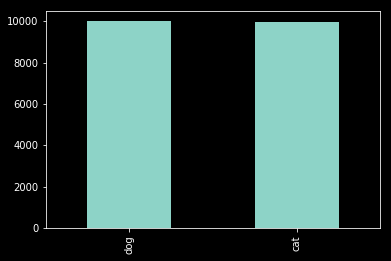

In [136]:
train_df['category'].value_counts().plot.bar()

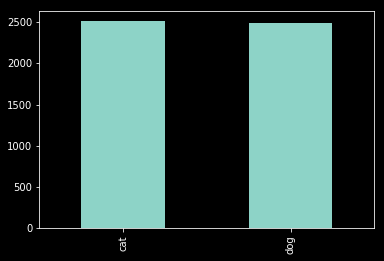

In [123]:
validate_df['category'].value_counts().plot.bar()

As we saw before , shapes of images were different. Therefore we should use ImageGenerator

In [124]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../train/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=25
)

Found 19999 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [125]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../train/train/train", 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=25
)

Found 5001 validated image filenames belonging to 2 classes.


So it seems every thing is ready! so lets build the model

In [137]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1,factor=0.5, in_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

history = model.fit_generator(
    train_generator, 
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validate_df.shape[0]//25,
    steps_per_epoch=train_df.shape[0]//25,
    callbacks=callbacks
)

Epoch 1/10
800/800 [==============================] - 141s 176ms/step - loss: 0.7794 - accuracy: 0.6273 - val_loss: 1.0626 - val_accuracy: 0.5558
Epoch 2/10
  5/800 [..............................] - ETA: 25s - loss: 0.5536 - accuracy: 0.7200

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


800/800 [==============================] - 139s 174ms/step - loss: 0.5356 - accuracy: 0.7309 - val_loss: 0.5234 - val_accuracy: 0.7295
Epoch 3/10
800/800 [==============================] - 140s 175ms/step - loss: 0.4766 - accuracy: 0.7741 - val_loss: 0.4750 - val_accuracy: 0.8159
Epoch 4/10
800/800 [==============================] - 141s 176ms/step - loss: 0.4380 - accuracy: 0.8007 - val_loss: 0.5247 - val_accuracy: 0.8252
Epoch 5/10
800/800 [==============================] - 141s 176ms/step - loss: 0.4090 - accuracy: 0.8167 - val_loss: 0.3915 - val_accuracy: 0.8633
Epoch 6/10
800/800 [==============================] - 142s 178ms/step - loss: 0.3864 - accuracy: 0.8283 - val_loss: 0.2183 - val_accuracy: 0.8366
Epoch 7/10
800/800 [==============================] - 140s 176ms/step - loss: 0.3747 - accuracy: 0.8342 - val_loss: 0.4558 - val_accuracy: 0.8344
Epoch 8/10
800/800 [==============================] - 141s 176ms/step - loss: 0.3623 - accuracy: 0.8398 - val_loss: 0.5014 - val_accura

In [138]:
import zipfile
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip", 'r') as zip_ref:
    zip_ref.extractall("../test_model/")

In [139]:
test_filenames = os.listdir("../test_model/test1/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
print(nb_samples)

12500


In [140]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../test_model/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(128, 128),
    batch_size=25,
    shuffle=False
)

Found 12500 validated image filenames.


In [141]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/25))

In [142]:
test_df['category'] = np.argmax(predict, axis=-1)

In [143]:
test_df.head(10)

,filename,category
0,10435.jpg,0
1,6790.jpg,1
2,4644.jpg,0
3,1835.jpg,0
4,1102.jpg,0
5,8962.jpg,0
6,6040.jpg,1
7,4423.jpg,0
8,12072.jpg,0
9,1806.jpg,0


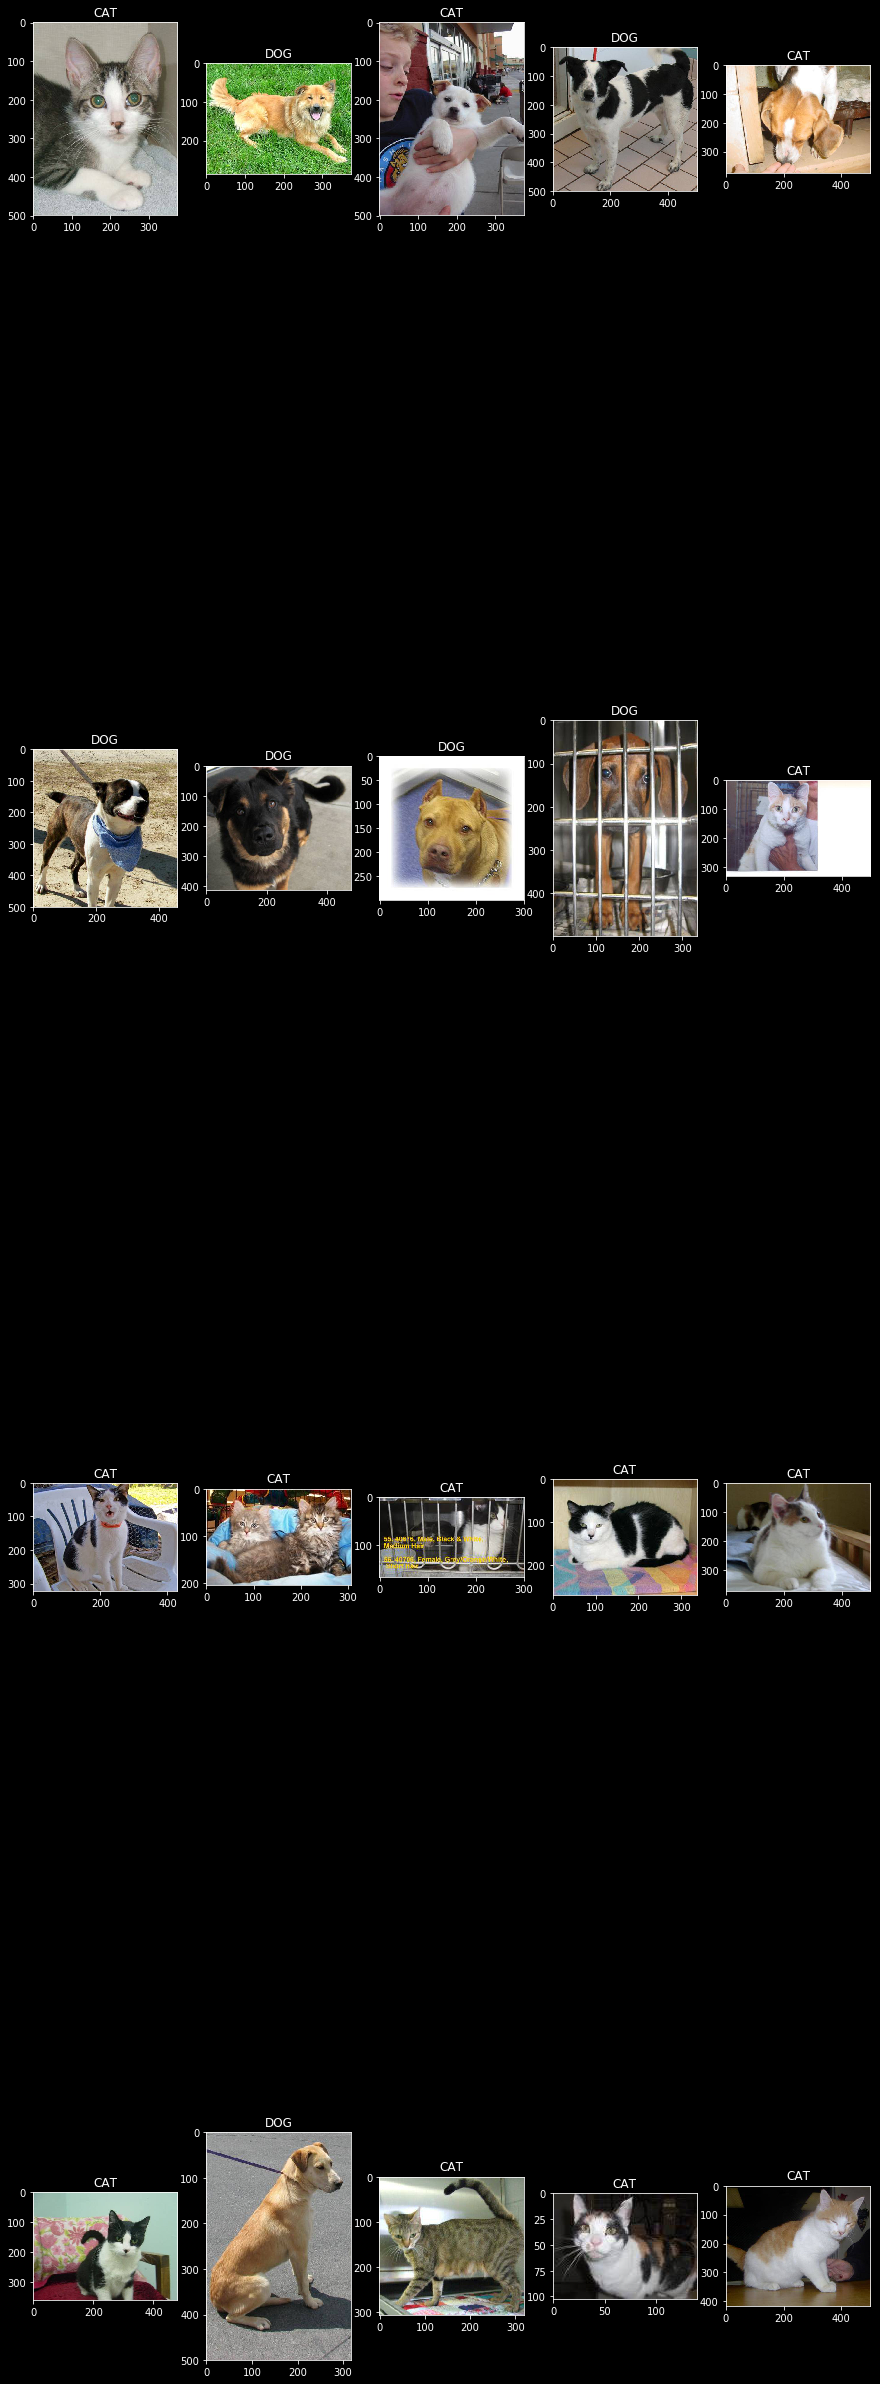

In [150]:
plt.figure(figsize=(15, 20))
n = test_df.shape[0]
for i in range(20):
    rand = random.randrange(n)
    plt.subplot(4, 5, i + 1)
    sample = test_df["filename"][rand]
    image = load_img("../test_model/test1/" + sample)
    plt.title(["CAT", "DOG"][test_df["category"][rand]])
    plt.imshow(image)